In [39]:
import numpy as np
import pandas as pd
import re
import seaborn as sn
import os
import matplotlib.pyplot as plt

In [40]:
df_keys = ["n_data", "comp_time_total", 
           "time/chain_max", "time/chain_min", "time/chain_mean",
           "MC_it_min", "MC_it_max", "MC_it_mean", "MC_it_total",
           "mix_max", "mix_min", "mix_mean",
           "MC_std_err_min", "MC_std_err_max", "MC_std_err_mean",
           "eff_size_min", "eff_size_max", "eff_size_mean",
           "thinning_min", "thinning_max", "thinning_mean",
           "file_size_MB"]
file_keys = ["time",
           "MC_it",
           "components",
           "MC_std_err_min", "MC_std_err_max",
           "eff_size_min", "eff_size_max",
           "thinning_min", "thinning_max"]
    
line_prefix = ["MCMC time",
               "USED COMPONENTS",
               "rel. MC standard error",
               "eff. sample size",
               "needed thinning",
               "Total number of iterations"]

df = pd.DataFrame(columns = df_keys)

In [41]:
def process(i, line, df):
    for prefix in line_prefix:
        #print(prefix)
        #print(line)
        if prefix in line:
            #print("match", line, prefix)

            if prefix == "MCMC time":
                time = int(re.findall('\d+', line)[0])
                # parse secs, mins, hours to seconds
                if "secs" in line:
                    time = time
                elif "mins" in line:
                    time = time*60
                elif "hours":
                    time = time*60*60
                df["time"][i] = time

            if prefix == "USED COMPONENTS":  
                string = re.split(r"\:", line)[-1]
                numbers = [int(num) for num in re.findall(r'[\d]+', string)]
                components = numbers[0]
                if np.isnan(df["components"][i]):
                    df["components"][i] = components

            if prefix == "Total number of iterations":
                numbers = [int(num) for num in re.findall(r'[\d]+', line)]
                remaining = numbers[1]
                if remaining == 0:
                    its_used = numbers[0]
                    df["MC_it"][i] = its_used
                    
            if prefix == "rel. MC standard error":
                string = re.split(r"\:", line)[-1]
                numbers = [float(num) for num in re.findall(r'[\d.]+', string)]
                low_value = numbers[0]
                high_value = numbers[1]
                df["MC_std_err_min"][i] = low_value
                df["MC_std_err_max"][i] = high_value

            if prefix == "eff. sample size":
                string = re.split(r"\:", line)[-1]
                numbers = [int(num) for num in re.findall(r'[\d]+', string)]
                low_value = numbers[0]
                high_value = numbers[1]
                df["eff_size_min"][i] = low_value
                df["eff_size_max"][i] = high_value

            if prefix == "needed thinning":
                string = re.split(r"\:", line)[-1]
                numbers = [int(num) for num in re.findall(r'[\d]+', string)]
                low_value = numbers[0]
                high_value = numbers[1]
                df["thinning_min"][i] = low_value
                df["thinning_max"][i] = high_value

    return df

In [42]:
def get_df(n_data, dir_names, log_files, df_keys, file_keys):
    df = pd.DataFrame(columns = df_keys, index = range(len(dir_names)))
    for i in range(len(dir_names)):
        df_dir = pd.DataFrame(columns = file_keys, index = range(len(log_files)))
        for j in range(len(log_files)):
            filename = f"{dir_names[i]}{log_files[j]}"
            with open(filename, 'r') as file:
                while True:
                    line = file.readline()
                    if not line:
                        break
                    # Process line of data
                    df_dir = process(j, line, df_dir)

        df["n_data"][i] = n_data[i]
        df["comp_time_total"][i] = df_dir["time"].sum()
        df["time/chain_max"][i] = df_dir["time"].max()
        df["time/chain_min"][i] = df_dir["time"].min()
        df["time/chain_mean"][i] = df_dir["time"].mean()
        df["MC_it_total"][i] = df_dir["MC_it"].sum()
        df["MC_it_min"][i] = df_dir["MC_it"].min()
        df["MC_it_max"][i] = df_dir["MC_it"].max()
        df["MC_it_mean"][i] = df_dir["MC_it"].mean()
        df["mix_max"][i] = df_dir["components"].max()
        df["mix_min"][i] = df_dir["components"].min()
        df["mix_mean"][i] = df_dir["components"].mean()
        df["MC_std_err_max"][i] = df_dir["MC_std_err_max"].max()
        df["MC_std_err_min"][i] = df_dir["MC_std_err_min"].min()
        df["MC_std_err_mean"][i] = np.mean(df_dir["MC_std_err_max"] - df_dir["MC_std_err_min"])
        df["eff_size_max"][i] = df_dir["eff_size_max"].max()
        df["eff_size_min"][i] = df_dir["eff_size_min"].min()
        df["eff_size_mean"][i] = np.mean(df_dir["eff_size_max"] - df_dir["eff_size_min"])
        df["thinning_max"][i] = df_dir["thinning_max"].max()
        df["thinning_min"][i] = df_dir["thinning_min"].min()
        df["thinning_mean"][i] = np.mean(df_dir["thinning_max"] - df_dir["thinning_min"])
        # File size
        df["file_size_MB"][i] = os.path.getsize(f"{dir_names[i]}learnt.rds")/10**6
    return df

In [43]:
# Setup

n_plots = 6
n_samples = 1200
n_data = [250, 1000, 2000, 2100, 3000, 3600, 4000, 5000]
n_chains = [10]*len(n_data)
polar = False

y_labels = ["red", "blue"]
if polar:
    x_labels = ["r_x", "a_x"]
else:
    x_labels = ["x1", "x2"]
#nsamples = 1200
R2 = 3
k_red = 7
k_blue = 3
R1_min = 6
scale = 1
vary_a1 = False
vary_R2 = False
p_red = 0.5
tag = f'r2_{R2}_kr{k_red}_kb{k_blue}_r1min{R1_min}_s{scale}_vary_r2_{vary_R2}_vary_a1_{vary_a1}_pRed_{p_red}'

train_n = 50000
trainfile = f"train_n_{train_n}_{tag}"


testfile = "x1_x2_grid"
weight_key = f"P({y_labels[1]}|x)"

if polar:
    analysis_folders = [f"inference/{trainfile}/nsamples-1200_nchains-{n_chains[i]}_ndata-{n_data[i]}_POLAR/" for i in range(n_plots)]
else:
    analysis_folders = [f"inference/{trainfile}/nsamples-1200_nchains-{n_chains[i]}_ndata-{n_data[i]}/" for i in range(n_plots)]

log_files = [f"log-{i}.log" for i in range(1, len(n_chains))]

df_normal = get_df(n_data, analysis_folders, log_files, df_keys, file_keys)
df_normal

,n_data,comp_time_total,time/chain_max,time/chain_min,time/chain_mean,MC_it_min,MC_it_max,MC_it_mean,MC_it_total,mix_max,...,MC_std_err_min,MC_std_err_max,MC_std_err_mean,eff_size_min,eff_size_max,eff_size_mean,thinning_min,thinning_max,thinning_mean,file_size_MB
0,250,3120,840,240,445.714286,9067,39419,19133.428571,133934,40,...,0.00584,0.0499,0.040976,401,29300,15523.571429,2,144,68.428571,4.102854
1,1000,8220,3600,420,1174.285714,3600,50080,13038.142857,91267,53,...,0.00489,0.0499,0.034139,401,41800,11683.285714,1,188,44.857143,4.092139
2,2000,12480,3420,840,1782.857143,3600,23045,9539.285714,66775,62,...,0.00704,0.05,0.03342,401,20200,9163.714286,1,87,31.857143,4.085858
3,2100,12540,3600,960,1791.428571,3600,24410,8990.571429,62934,61,...,0.0062,0.0493,0.033556,412,26000,9831.142857,1,87,29.0,4.084218
4,3000,20520,7200,1260,2931.428571,3600,41535,13296.285714,93074,63,...,0.00488,0.05,0.037166,400,41900,13473.0,2,151,46.714286,4.081308
5,3600,44460,14400,2340,6351.428571,7483,57173,23825.0,166775,65,...,0.00414,0.0498,0.04172,403,58300,23906.571429,2,213,86.714286,4.081984


Text(0.5, 1.0, '2 continous variables, 1 discrete, 5 test points')

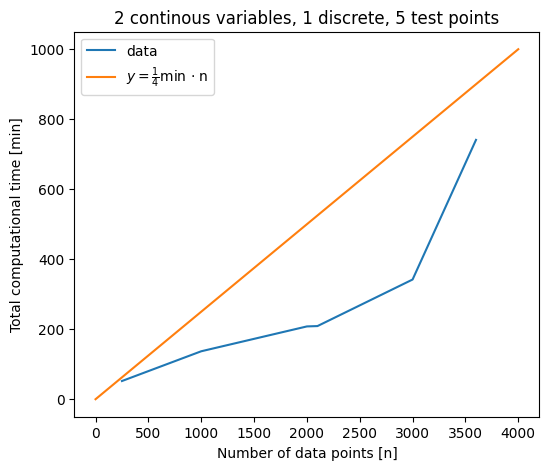

In [44]:
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (6, 5))
df_normal["comp_time_total_mins"] = df_normal["comp_time_total"]/60
sn.lineplot(data = df_normal, x = "n_data", y = "comp_time_total_mins", label="data", ax = ax)
ax.set_xlabel("Number of data points [n]")
ax.set_ylabel("Total computational time [min]")
x = np.arange(0, 2**12, 500)
#ax.plot(x, x/60, label="y=x")
ax.plot(x, 10*x/40, label=r"$y=\frac{1}{4}$min $\cdot$ n")
ax.legend()
ax.set_title("2 continous variables, 1 discrete, 5 test points")

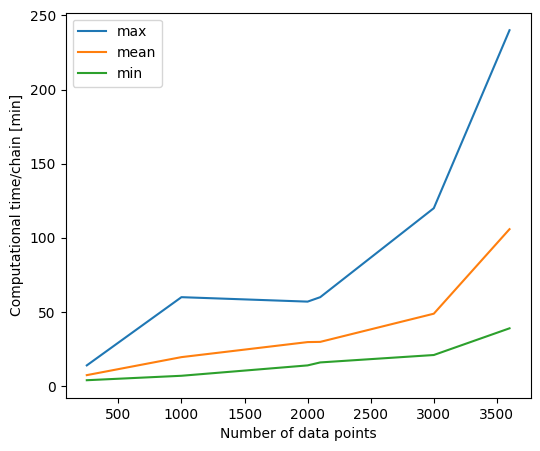

In [45]:
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (6, 5))
df_normal["time/chain_max_mins"] = df_normal["time/chain_max"]/60
df_normal["time/chain_mean_mins"] = df_normal["time/chain_mean"]/60
df_normal["time/chain_min_mins"] = df_normal["time/chain_min"]/60
sn.lineplot(data = df_normal, x = "n_data", y = "time/chain_max_mins", label="max", ax = ax)
sn.lineplot(data = df_normal, x = "n_data", y = "time/chain_mean_mins", label="mean", ax = ax)
sn.lineplot(data = df_normal, x = "n_data", y = "time/chain_min_mins", label="min", ax = ax)
ax.set_xlabel("Number of data points")
ax.set_ylabel("Computational time/chain [min]")
x = np.linspace(0, 2**12, 500)
#ax.plot(x, (3/4)*(1/20)*x, label=r"$y=\frac{3}{80}$x")
ax.legend()

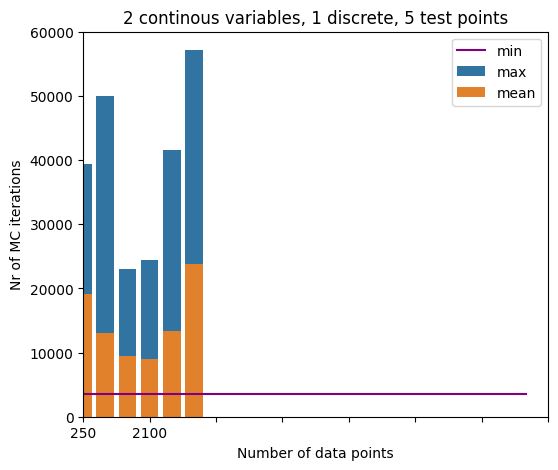

In [46]:
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (6, 5))
sn.barplot(data = df_normal, x = "n_data", y = "MC_it_max", label="max", ax = ax)
sn.barplot(data = df_normal, x = "n_data", y = "MC_it_mean", label="mean", ax = ax)
ax.set_xlabel("Number of data points")
ax.set_ylabel("Nr of MC iterations")
x = np.linspace(0, 20, 100)
ax.plot(x, x*0 + 3600, label="min", color="purple")
#ax.plot(x, 10*x, label="y=10x")
ax.set_xlim(0, 2)
ax.set_xticks([3*i for i in range(8)])
ax.set_title("2 continous variables, 1 discrete, 5 test points")
ax.legend()

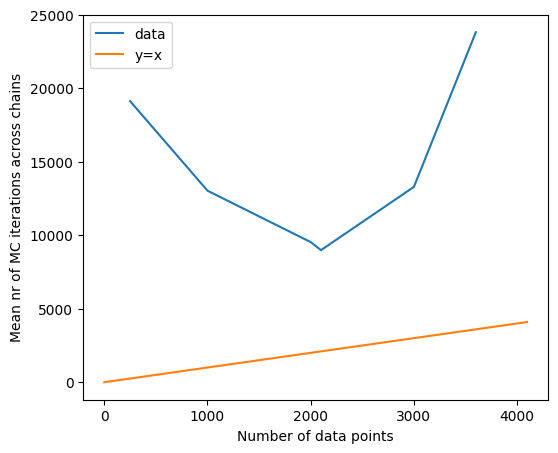

In [47]:
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (6, 5))
sn.lineplot(data = df_normal, x = "n_data", y = "MC_it_mean", label="data", ax = ax)
ax.set_xlabel("Number of data points")
ax.set_ylabel("Mean nr of MC iterations across chains")
x = np.linspace(0, 2**12, 500)
ax.plot(x, x, label="y=x")
#ax.plot(x, 10*x, label="y=10x")
ax.legend()

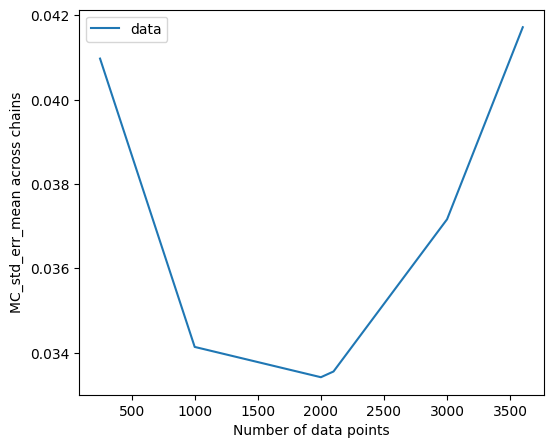

In [48]:
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (6, 5))
sn.lineplot(data = df_normal, x = "n_data", y = "MC_std_err_mean", label="data", ax = ax)
ax.set_xlabel("Number of data points")
ax.set_ylabel("MC_std_err_mean across chains")
#x = np.arange(0, 2**12, 500)
#ax.plot(x, x, label="y=x")
#ax.plot(x, 10*x, label="y=10x")
ax.legend()